Model Accuracy: 99.90%


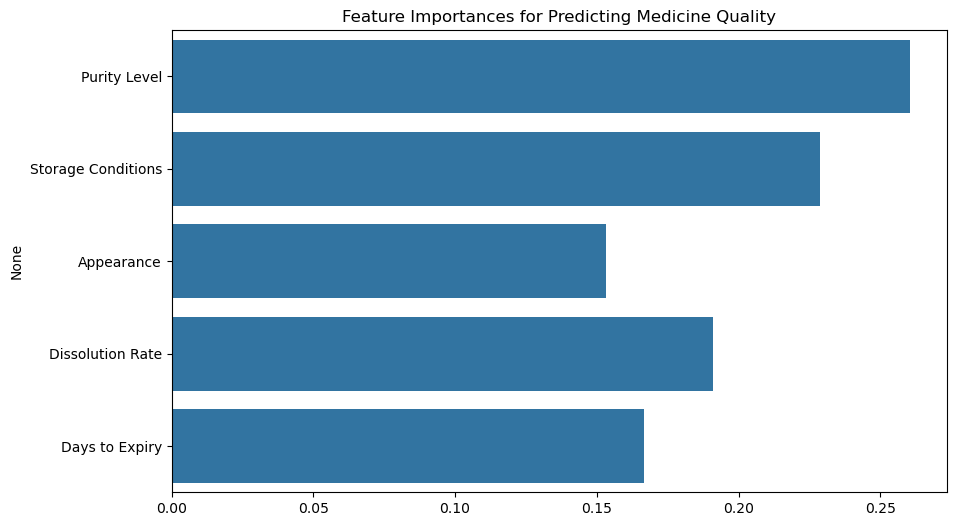

Medicine Name: Unrecognized (Encoded: Antibiotic)
Expiration Date: 2025-12-07T00:00:00.000000000
Manufacture Date: 2021-05-28T00:00:00.000000000
Dissolution Rate: 93.29
Quality Check: Good


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


df = pd.read_csv('medicine_quality_dataset.csv')
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Manufacture Date'] = pd.to_datetime(df['Manufacture Date'])
label_encoder = LabelEncoder()
#df['Medicine Name'] = label_encoder.fit_transform(df['Medicine Name'])  # Fit on all data
df['Chemical Composition'] = label_encoder.fit_transform(df['Chemical Composition'])
df['Storage Conditions'] = label_encoder.fit_transform(df['Storage Conditions'])
df['Appearance'] = label_encoder.fit_transform(df['Appearance'])
def check_quality(row):
    if (row['Purity Level'] >= 95 and 
        row['Dissolution Rate'] >= 90 and 
        row['Storage Conditions'] == 0 and  # Assume 'Refrigerated' is encoded as 0
        row['Appearance'] != 2 and  # Assume 'Cloudy' is encoded as 2
        row['Expiration Date'] > pd.Timestamp.now()):
        return 'Good'
    else:
        return 'Bad'
        
df['Quality Check'] = df.apply(check_quality, axis=1)
X = df[['Purity Level', 'Expiration Date', 'Storage Conditions', 'Appearance', 'Dissolution Rate']].copy()
y = df['Quality Check']
X['Days to Expiry'] = (df['Expiration Date'] - pd.Timestamp.now()).dt.days
X = X.drop('Expiration Date', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')
def predict_quality(batch_number):
    if 'Batch Number' not in df.columns:
        return "Error: 'Batch Number' column not found."

 
    batch_data = df[df['Batch Number'] == batch_number]
    if batch_data.empty:
        return "Batch number not found."

    features = batch_data[['Purity Level', 'Storage Conditions', 'Appearance', 'Dissolution Rate']].copy()
    
    
    features.loc[:, 'Days to Expiry'] = (batch_data['Expiration Date'] - pd.Timestamp.now()).dt.days


    predicted_quality = model.predict(features)

   
    medicine_name_encoded = batch_data['Medicine Name'].values[0]
    try:
        medicine_name = label_encoder.inverse_transform([medicine_name_encoded])[0]
    except ValueError:
        medicine_name = f"Unrecognized (Encoded: {medicine_name_encoded})"
    
    return {
        'Medicine Name': medicine_name,
        'Expiration Date': batch_data['Expiration Date'].values[0],
        'Manufacture Date': batch_data['Manufacture Date'].values[0],
        'Dissolution Rate': batch_data['Dissolution Rate'].values[0],
        'Quality Check': predicted_quality[0]
    }

feature_importances = model.feature_importances_
features_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features_names)
plt.title("Feature Importances for Predicting Medicine Quality")
plt.show()
batch_number_input = 386850		
result = predict_quality(batch_number_input)

#CHECKING 
if isinstance(result, dict):
    print(f"Medicine Name: {result['Medicine Name']}")
    print(f"Expiration Date: {result['Expiration Date']}")
    print(f"Manufacture Date: {result['Manufacture Date']}")
    print(f"Dissolution Rate: {result['Dissolution Rate']}")
    print(f"Quality Check: {result['Quality Check']}")
else:
    print(result)